# Cloning Items and Remapping Data

Alright, so now we've got this super sweet time-enabled feature layer about the Gulf Stream, but what if we were only testing that out, and now want to bring it to a production org? Or, what if that notebook/feature layer was created on an Enterprise, and we want to bring it to Online and share it publicly for the whole world to see? Well, that's where the [`ContentManager`'s](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#contentmanager) `clone_items()` function comes in. `clone_items()` is one of the most frequently asked about parts of our API- it's a function that allows you to duplicate a given item in another organization, including with all of the internal items it may depend on. 

There are tons of different parameters the function can take that will allow for a user to customize their cloning experience; we're just going to go over some of the basics here to show how we can get our items to another organization and assure that they're pointing to the right internal items.

In [3]:
from arcgis.gis import GIS
gis = GIS(profile="your_online_profile")
gis2 = GIS(profile="noah_oceans")

/opt/anaconda3/envs/uc2024/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Let's grab our feature layer item- it'd be great to bring that over to our new org so we can add to it there.

<Item title:"Time Enabled Gulf Stream Layer" type:Feature Layer Collection owner:nparavicini_geosaurus>
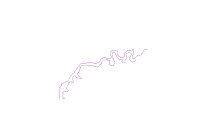

In [4]:
fl = gis.content.get("cc1f8377231b4247b5085e89635dc537")
fl

In [6]:
clone_list = gis2.content.clone_items([fl], search_existing_items = False)
clone_list

/opt/anaconda3/envs/uc2024/lib/python3.11/tempfile.py:934: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/dn/rybvglf95w710d__8w91yngc0000gn/T/tmp44ghq2w8'>
  _warnings.warn(warn_message, ResourceWarning)
/opt/anaconda3/envs/uc2024/lib/python3.11/tempfile.py:934: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/dn/rybvglf95w710d__8w91yngc0000gn/T/tmpp8qsqk4k'>
  _warnings.warn(warn_message, ResourceWarning)


[<Item title:"Time Enabled Gulf Stream Layer" type:Feature Layer Collection owner:Noah_Oceans>]

<Item title:"Time Enabled Gulf Stream Layer" type:Feature Layer Collection owner:Noah_Oceans>
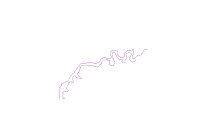

In [5]:
new_fl = clone_list[0]
new_fl

One important thing to notice there is the `search_existing_items` argument- if `True`, it searches the target organization to see if the same item has already been cloned. If it has already been cloned, it won't get cloned again, and the already-existent clone will be used where necessary. If `False`, it will clone all the items passed into the function and their dependent items no matter what.

Let's see what happens if we try to clone that same feature layer again, just with the argument set to `True`.

In [5]:
clone_list2 = gis2.content.clone_items([fl], search_existing_items = True)
clone_list2

[]

## Remapping Data

What if we want to point our data to specific other things that already exist? We can use the `item_mapping` parameter, which allows you to specify item id's to be replaced. Just have a 1-to-1 key value mapping of id's. The value id's must exist in the target org.

In [ ]:
# exp = gis.content.get("b2136e64f7414d10b02b52b009d7c13b")
wm = gis.content.get("bf5a039b1947422190b5812fc34af717")
item_mapping = {"d322ea73f27844228a2f235d9615854e": "f97da123d5684bd4b31842b94985635a"}
clone_exp = gis2.content.clone_items([wm], item_mapping = item_mapping, search_existing_items = False)

In [7]:
clone_exp

[<Item title:"Ugly Map" type:Web Map owner:Noah_Oceans>]

<Item title:"Ugly Map" type:Web Map owner:nparavicini_geosaurus>
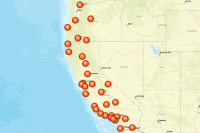

In [8]:
wm = gis.content.get("bf5a039b1947422190b5812fc34af717")
wm

In [9]:
clone_exp

[<Item title:"Ugly Map" type:Web Map owner:Noah_Oceans>]

And there we go- as we can see, we got the stuff to clone over and take advantage of stuff that already existed in the target organization. We can confirm it by looking in the data of the items we cloned over.

In [10]:
clone_exp[0].get_data()

{'operationalLayers': [{'id': '1890ec15ae5-layer-1',
   'title': 'CA OR Airports - ad363a',
   'url': 'https://services.arcgis.com/bDAhvQYMG4WL8O5o/arcgis/rest/services/a7998a_4ce24/FeatureServer/0',
   'itemId': 'f97da123d5684bd4b31842b94985635a',
   'layerType': 'ArcGISFeatureLayer',
   'popupInfo': {'popupElements': [{'type': 'fields'},
     {'type': 'attachments', 'displayType': 'auto'}],
    'showAttachments': True,
    'fieldInfos': [{'fieldName': 'FID',
      'isEditable': False,
      'label': 'FID',
      'visible': False},
     {'fieldName': 'airport',
      'isEditable': True,
      'label': 'AIRPORT',
      'visible': True},
     {'fieldName': 'city',
      'isEditable': True,
      'label': 'CITY',
      'visible': True},
     {'fieldName': 'country',
      'isEditable': True,
      'label': 'COUNTRY',
      'visible': True},
     {'fieldName': 'iata',
      'isEditable': True,
      'label': 'IATA',
      'visible': True},
     {'fieldName': 'latitude',
      'format': {'

So, as we can see, the item id of our new layer was added into there- but other things, like the title of the layer, were not changed. This is because this `item_mapping` parameter was added in with the intention of allowing users to explicitly specify their own versions of the same item. But what if the users have a need to replace something entirely? What if they want to remap the data to something completely new and have the associated info update accordingly? What if we have non-itemid parts of the structure we want to change? Or what if they already have an item in their new org that has bad data, and they don't want to clone it to go through the the remapping process?

Well luckily, we're adding in a new function coming up called `remap_data()` that addresses these concerns- here's a sneak preview.

We'll start with an already cloned version of our new Web Map (that hasn't been edited) and see what happens when we call `remap_data()` on it to replace the feature layer inside of it.

<Item title:"Ugly Map" type:Web Map owner:Noah_Oceans>
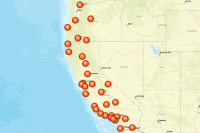

In [11]:
bad_clone = gis2.content.get("065d73980eda4a3ba37b74bbc1a8bed7")
bad_clone

In [12]:
bad_clone.get_data()

{'operationalLayers': [{'id': '1890ec15ae5-layer-1',
   'title': 'Gulf Stream Yay!',
   'url': 'https://services.arcgis.com/bDAhvQYMG4WL8O5o/arcgis/rest/services/a7998a_4ce24/FeatureServer/0',
   'itemId': 'f97da123d5684bd4b31842b94985635a',
   'layerType': 'ArcGISFeatureLayer',
   'popupInfo': {'popupElements': [{'type': 'fields'},
     {'type': 'attachments', 'displayType': 'auto'}],
    'showAttachments': True,
    'fieldInfos': [{'fieldName': 'fid0',
      'isEditable': False,
      'label': 'FID',
      'visible': False},
     {'fieldName': 'airport',
      'isEditable': True,
      'label': 'AIRPORT',
      'visible': True},
     {'fieldName': 'city',
      'isEditable': True,
      'label': 'CITY',
      'visible': True},
     {'fieldName': 'country',
      'isEditable': True,
      'label': 'COUNTRY',
      'visible': True},
     {'fieldName': 'iata',
      'isEditable': True,
      'label': 'IATA',
      'visible': True},
     {'fieldName': 'latitude',
      'format': {'digitS

We'll define our mapping dict in the exact same way that we did earlier- item id key/value pairs.

In [14]:
new_mapping = {"f97da123d5684bd4b31842b94985635a" : "d30eb25743c748e29d72880988a272d6"}

In [15]:
bad_clone.remap_data(new_mapping)

True

In [ ]:
bad_clone

In [16]:
bad_clone.get_data()

{'operationalLayers': [{'id': '1890ec15ae5-layer-1',
   'title': 'Gulf Stream Yay!',
   'url': 'https://services.arcgis.com/bDAhvQYMG4WL8O5o/arcgis/rest/services/ad363a_87e5a_9c45c_20fa3/FeatureServer/0',
   'itemId': 'd30eb25743c748e29d72880988a272d6',
   'layerType': 'ArcGISFeatureLayer',
   'popupInfo': {'popupElements': [{'type': 'fields'},
     {'type': 'attachments', 'displayType': 'auto'}],
    'showAttachments': True,
    'fieldInfos': [{'fieldName': 'fid0',
      'isEditable': False,
      'label': 'FID',
      'visible': False},
     {'fieldName': 'airport',
      'isEditable': True,
      'label': 'AIRPORT',
      'visible': True},
     {'fieldName': 'city',
      'isEditable': True,
      'label': 'CITY',
      'visible': True},
     {'fieldName': 'country',
      'isEditable': True,
      'label': 'COUNTRY',
      'visible': True},
     {'fieldName': 'iata',
      'isEditable': True,
      'label': 'IATA',
      'visible': True},
     {'fieldName': 'latitude',
      'forma

As we can see, it changed properly! It now uses our other feature layer.

However, what if we also want to change other parts of the structure? Like the title of the layer? Well luckily, we can also use this item to do that. However, be warned, using force in this function will override any failsafes and is only recommended for users confident in their item structure.

In [19]:
text_replace = {"Gulf Stream Yay!": "CA OR Airports - ad363a" }
bad_clone.remap_data(text_replace, force = True)

True

Now, if we take a look, we should get one with the right name. Tada!!!

In [20]:
bad_clone.get_data()

{'operationalLayers': [{'id': '1890ec15ae5-layer-1',
   'title': 'CA OR Airports - ad363a',
   'url': 'https://services.arcgis.com/bDAhvQYMG4WL8O5o/arcgis/rest/services/ad363a_87e5a_9c45c_20fa3/FeatureServer/0',
   'itemId': 'd30eb25743c748e29d72880988a272d6',
   'layerType': 'ArcGISFeatureLayer',
   'popupInfo': {'popupElements': [{'type': 'fields'},
     {'type': 'attachments', 'displayType': 'auto'}],
    'showAttachments': True,
    'fieldInfos': [{'fieldName': 'fid0',
      'isEditable': False,
      'label': 'FID',
      'visible': False},
     {'fieldName': 'airport',
      'isEditable': True,
      'label': 'AIRPORT',
      'visible': True},
     {'fieldName': 'city',
      'isEditable': True,
      'label': 'CITY',
      'visible': True},
     {'fieldName': 'country',
      'isEditable': True,
      'label': 'COUNTRY',
      'visible': True},
     {'fieldName': 'iata',
      'isEditable': True,
      'label': 'IATA',
      'visible': True},
     {'fieldName': 'latitude',
     